# GPU-accelerated interactive visualization of single cells with RAPIDS, Scanpy and Plotly Dash

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In this notebook, we cluster cells based on a single-cell RNA-seq count matrix, and produce an interactive visualization of the clustered cells that allows for further analysis of the data in a browser window.

For demonstration purposes, we use a dataset of ~70,000 human lung cells from Travaglini et al. 2020 (https://www.biorxiv.org/content/10.1101/742320v2) and label cells using the ACE2, TMPRSS2, and EPCAM marker genes.

## Import requirements

In [1]:
import scanpy as sc
import anndata

import sys
import time

import os, wget

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs

import warnings
warnings.filterwarnings('ignore', 'Expected ')

We use the RAPIDS memory manager on the GPU to control how memory is allocated.

In [2]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

We recommend saving count matrices in the sparse .h5ad format as it is much faster to load than a dense CSV file. To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [3]:
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/krasnow_hlca_10x.sparse.h5ad',
                  input_file)

## Set parameters

In [4]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [5]:
%%time
adata = sc.read(input_file)

CPU times: user 160 ms, sys: 662 ms, total: 822 ms
Wall time: 1.08 s


In [6]:
adata.shape

(65662, 26485)

In [7]:
%%time
genes = cudf.Series(adata.var_names)
barcodes = cudf.Series(adata.obs_names)
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

CPU times: user 1.19 s, sys: 1.18 s, total: 2.37 s
Wall time: 2.37 s


## Preprocessing

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sparse_gpu_array, barcodes = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell, barcodes=barcodes)

CPU times: user 679 ms, sys: 676 ms, total: 1.35 s
Wall time: 1.38 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=1)

CPU times: user 802 ms, sys: 238 ms, total: 1.04 s
Wall time: 1.04 s


The size of our count matrix is now reduced.

In [10]:
sparse_gpu_array.shape

(65462, 22058)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [11]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.normalize_total(sparse_gpu_array, target_sum=1e4)

CPU times: user 2.59 ms, sys: 0 ns, total: 2.59 ms
Wall time: 3.73 ms


Next, we log transform the count matrix.

In [12]:
%%time
sparse_gpu_array = sparse_gpu_array.log1p()

CPU times: user 52.8 ms, sys: 42 ms, total: 94.8 ms
Wall time: 96.1 ms


### Select Most Variable Genes

We first save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of an epithelial marker gene (EPCAM).

In [13]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

CPU times: user 292 ms, sys: 186 ms, total: 478 ms
Wall time: 492 ms


We identify the top 5000 variable genes using the `cellranger` method.

In [14]:
%time
hvg = rapids_scanpy_funcs.highly_variable_genes(sparse_gpu_array, genes, n_top_genes=5000)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.29 µs


We filter the count matrix to retain only the 5000 most variable genes.

In [15]:
%%time
sparse_gpu_array = sparse_gpu_array[:, hvg]
genes = genes[hvg].reset_index(drop=True)
sparse_gpu_array.shape

CPU times: user 203 ms, sys: 91.6 ms, total: 295 ms
Wall time: 304 ms


(65462, 5000)

### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [16]:
%%time
ribo_genes = genes.str.startswith(RIBO_GENE_PREFIX)

n_counts = sparse_gpu_array.sum(axis=1)
percent_ribo = (sparse_gpu_array[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

CPU times: user 35 ms, sys: 20.4 ms, total: 55.4 ms
Wall time: 56.4 ms


And perform regression:

In [17]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array, n_counts, percent_ribo)

CPU times: user 15.6 s, sys: 20 s, total: 35.6 s
Wall time: 36 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [18]:
%%time
sparse_gpu_array = StandardScaler().fit_transform(sparse_gpu_array).clip(a_max=10)

CPU times: user 1.2 s, sys: 754 ms, total: 1.96 s
Wall time: 2.02 s


## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. 
We also add the barcodes of the filtered cells, and the expression levels of the marker genes, to the annData object.

In [19]:
%%time

adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()
adata.obs_names = barcodes.to_pandas()
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

CPU times: user 285 ms, sys: 448 ms, total: 733 ms
Wall time: 731 ms


### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [20]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)

CPU times: user 1.44 s, sys: 1.3 s, total: 2.75 s
Wall time: 2.75 s


### UMAP + clustering

We visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

Note that Scanpy uses an approximation to the nearest neighbors on the CPU while the GPU version performs an exact search. While both methods are known to yield useful results, some differences in the resulting visualization and clusters can be observed.

In [21]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 4.31 s, sys: 414 ms, total: 4.73 s
Wall time: 4.93 s


The UMAP function from Rapids is also integrated into Scanpy.

In [22]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 268 ms, sys: 240 ms, total: 509 ms
Wall time: 508 ms


Finally, we use the Leiden algorithm for graph-based clustering.

In [23]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata, resolution=0.1)

CPU times: user 79.6 ms, sys: 16.4 ms, total: 96 ms
Wall time: 95 ms


We plot the cells using the UMAP visualization, using the Louvain clusters as labels.

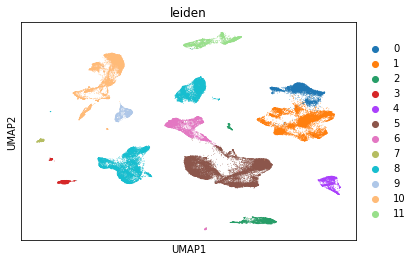

In [24]:
sc.pl.umap(adata, color=["leiden"])

## Defining re-clustering function for interactive visualization 

As we have shown above, the speed of RAPIDS allows us to run steps like dimension reduction, clustering and visualization in seconds or even less. In the sections below, we create an interactive visualization that takes advantage of this speed by allowing users to cluster and analyze selected groups of cells at the click of a button.

First, we create a function named `re_cluster`. This function can be called on selected groups of cells. According to the function defined below, PCA, KNN, UMAP and Louvain clustering will be re-computed upon the selected cells. You can customize this function for your desired analysis.

In [25]:
def re_cluster(adata):
    
    #### Function to repeat clustering and visualization on subsets of cells
    #### Runs PCA, KNN, UMAP and Leiden clustering on selected cells.
    adata.obsm["X_pca"] = PCA(n_components=n_components, output_type="numpy").fit_transform(adata.X)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
    sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
    adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

    return adata

## Creating an interactive visualization with Plotly Dash

<img src="https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/images/dashboard.png?raw=true" alt="Interactive Dashboard" width="400"/>

Below, we create the interactive visualization using the `adata` object and the re-clustering function defined above. To learn more about how this visualization is built, see `visualize.py`.

When you run the cell below, it returns a link. Click on this link to access the interactive visualization within your browser. 

Once opened, click the `Directions` button for instructions.

In [26]:
import visualize

v = visualize.Visualization(adata, markers, re_cluster_callback=re_cluster)
v.start('0.0.0.0')
1
selected_cells = v.new_df 

Dash is running on http://0.0.0.0:5000/

 * Serving Flask app 'visualize' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


Within the dashboard, you can select cells using a variety of methods. You can then cluster, visualize and analyze the selected cells using the tools provided. Click on the `Directions` button for details. 

To export the selected cells and the results of your analysis back to the notebook, click the `Export to Dataframe` button. This exports the results of your analysis back to this notebook, and closes the interactive dashboard. 

See the next section for instructions on how to use the exported data.

## Exporting a selection of cells from the dashboard

If you exported a selection cells from the interactive visualization, your selection will be available here as a data frame named `selected_cells`. The `labels` column of this dataframe contains the newly generated cluster labels assigned to these selected cells.

In [27]:
print(selected_cells.shape)
selected_cells.head()

(0, 0)


""


You can link the selected cells to the original `adata` object using the cell barcodes.

In [ ]:
adata_selected_cells = adata[selected_cells.barcode.to_array(),:]

In [ ]:
adata_selected_cells = adata[selected_cells.barcode.to_array(),:]
adata_selected_cells